# 肺結節の良悪性判定(K-Fold 交差検証)

## 前準備
### 主要パッケージを読み込む
loggerの設定も行う

In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from logging import basicConfig, getLogger, INFO
basicConfig(level=INFO, format='%(asctime)s %(levelname)s :%(message)s')
logger = getLogger(__name__)

### データディレクトリの指定

In [2]:
DATA_ROOT = pathlib.Path('Data/Images/LIDC_PN')
CLASS_LABELS = ('benign', 'malignant')
IMAGE_EXT = '.png'

### 画像ファイルを基にpd.DataFrameを作成する
クラスごとにDataFrameを作成した後に結合する。

In [3]:
import tut_utils
df_dataset = tut_utils.create_dataset_df(DATA_ROOT, CLASS_LABELS, IMAGE_EXT)
assert set(CLASS_LABELS) == set(df_dataset['class_label'].unique(
)), 'Discrepancy between CLASS_LABELS and df_dataset'
display(df_dataset)

,filepath,class_label,class
0,Data\Images\LIDC_PN\benign\001.png,benign,0
1,Data\Images\LIDC_PN\benign\002.png,benign,0
2,Data\Images\LIDC_PN\benign\007.png,benign,0
3,Data\Images\LIDC_PN\benign\011.png,benign,0
4,Data\Images\LIDC_PN\benign\012.png,benign,0
...,...,...,...
604,Data\Images\LIDC_PN\malignant\177.png,malignant,1
605,Data\Images\LIDC_PN\malignant\178.png,malignant,1
606,Data\Images\LIDC_PN\malignant\179.png,malignant,1
607,Data\Images\LIDC_PN\malignant\180.png,malignant,1


### データ読み込み用の関数を作成

In [4]:
from PIL import Image
import torch

IMG_SHAPE = (1, 64, 64)


def load_img(filepath):
    img = Image.open(filepath)
    img = img.resize(IMG_SHAPE[1:])
    return np.atleast_3d(img)


def load_dataset(df, load_img):
    data = np.stack([load_img(filepath) for filepath in df['filepath']])
    labels = df['class'].to_numpy()
    return data.astype(np.float32), labels

## Data augmentation

data augmentation用の [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)を作成する

In [5]:
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, xs, ys, transform=None):
        self.xs = xs
        self.ys = ys
        self.transform = transform

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx):
        x, y = self.xs[idx], self.ys[idx]
        if self.transform:
            x, y = self.transform(x, y)

        return x, y

### 試しに適用
いくつかの画像に対して実際にaugmentationを適用し表示する

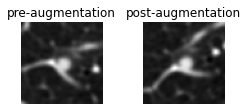

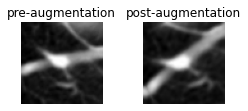

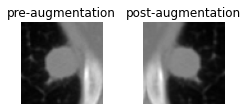

In [6]:
import albumentations as A

album_transform = A.Compose([
    A.Flip(p=.5),
    A.ShiftScaleRotate(shift_limit=0, scale_limit=.1, rotate_limit=45, p=.8)
])

N_TEST = 3


def random_transform(x, y):
    tfed = album_transform(image=x)
    x = tfed['image']
    x = x / 255
    x = x.transpose(2, 0, 1)  # to channels first
    return x.astype(np.float32), y.astype(np.float32)


def test_augmentation(df_dataset):
    df_train = df_dataset.iloc[:N_TEST]
    train_data, train_labels = load_dataset(df_train, load_img)
    dataset = AugmentedDataset(train_data, train_labels, random_transform)
    loader = torch.utils.data.DataLoader(dataset,
                                         batch_size=1,
                                         shuffle=False,
                                         num_workers=0)
    for i, data in enumerate(loader):
        plt.figure(figsize=(4, 1.5))
        plt.subplot(1, 2, 1)
        plt.imshow(train_data[i].squeeze(), cmap='gray')
        plt.title('pre-augmentation')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(data[0].squeeze(), cmap='gray')
        plt.title('post-augmentation')
        plt.axis('off')
        plt.show()


test_augmentation(df_dataset)

## ネットワーク定義

前に作成したものを使う

In [7]:
from tut_models import SimpleCNN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from torchsummary import summary
summary(SimpleCNN(), IMG_SHAPE, verbose=0, device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─ConvBNReLU: 2-1                   [-1, 4, 60, 60]           --
|    |    └─Sequential: 3-1              [-1, 4, 60, 60]           204
|    └─MaxPool2d: 2-2                    [-1, 4, 30, 30]           --
|    └─ConvBNReLU: 2-3                   [-1, 8, 26, 26]           --
|    |    └─Sequential: 3-2              [-1, 8, 26, 26]           912
|    └─MaxPool2d: 2-4                    [-1, 8, 13, 13]           --
|    └─ConvBNReLU: 2-5                   [-1, 16, 9, 9]            --
|    |    └─Sequential: 3-3              [-1, 16, 9, 9]            3,552
|    └─MaxPool2d: 2-6                    [-1, 16, 4, 4]            --
|    └─Dropout: 2-7                      [-1, 16, 4, 4]            --
|    └─Flatten: 2-8                      [-1, 256]                 --
|    └─Linear: 2-9                       [-1, 32]                  8,224
|    └─

## 学習を行う関数を作成
関数にするのは交差検証をやりやすくするため

In [8]:
import torch.optim as optim
import os

NUM_WORKERS = 0 if os.name == 'nt' else 2
BATCH_SIZE = 8


def train(net, train_data, train_labels, epochs):
    net.to(device)
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    dataset = AugmentedDataset(train_data, train_labels, random_transform)
    trainloader = torch.utils.data.DataLoader(dataset,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=NUM_WORKERS)

    for epoch in range(EPOCHS):
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            labels = labels.view(-1, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        loss = running_loss / len(trainloader)
        if epoch % 5 == 0:
            logger.info('[epoch=%d] loss: %.3f', epoch + 1, loss)


def test(net, data, labels):
    net.eval()
    with torch.no_grad():
        predictions = torch.sigmoid(net(data)).cpu().numpy().squeeze()
    y_pred = predictions > .5
    df_result = pd.DataFrame({
        'truth': labels,
        'pred_proba': predictions,
        'pred_class': y_pred
    })
    return df_result

## K-Fold 交差検証
分割にはsklearnの[StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)を使う。
<div class="alert alert-block alert-warning">
<b>注意:</b> 今回、epoch数は決め打ちしてありますが、本来はvalidationデータを用いて学習を終了させる必要があります。
</div>

In [9]:
from sklearn.model_selection import StratifiedKFold
K_FOLD = 3
EPOCHS = 32
kfold = StratifiedKFold(n_splits=K_FOLD, shuffle=True)

results = []
for i_iter, (train_index, test_index) in enumerate(
        kfold.split(df_dataset['filepath'], df_dataset['class'])):
    logger.info('{i}th iteration of {k}-fold CV'.format(i=i_iter + 1,
                                                        k=K_FOLD))
    df_train = df_dataset.iloc[train_index]
    df_test = df_dataset.iloc[test_index]
    train_data, train_labels = load_dataset(df_train, load_img)
    test_data, test_labels = load_dataset(df_test, load_img)
    net = SimpleCNN().to(device)
    train(net, train_data, train_labels, EPOCHS)
    logger.info('Finish training')
    test_data = torch.Tensor(test_data.transpose(0, 3, 1, 2) / 255).to(device)
    result = test(net, test_data, test_labels)
    result.index = test_index
    results.append(result)
#     break

2021-03-31 14:22:45,189 INFO :1th iteration of 3-fold CV
2021-03-31 14:22:47,515 INFO :[epoch=1] loss: 0.506
2021-03-31 14:22:49,266 INFO :[epoch=6] loss: 0.355
2021-03-31 14:22:50,998 INFO :[epoch=11] loss: 0.324
2021-03-31 14:22:52,730 INFO :[epoch=16] loss: 0.318
2021-03-31 14:22:54,445 INFO :[epoch=21] loss: 0.293
2021-03-31 14:22:56,168 INFO :[epoch=26] loss: 0.260
2021-03-31 14:22:57,897 INFO :[epoch=31] loss: 0.266
2021-03-31 14:22:58,241 INFO :Finish training
2021-03-31 14:22:58,250 INFO :2th iteration of 3-fold CV
2021-03-31 14:22:58,753 INFO :[epoch=1] loss: 0.595
2021-03-31 14:23:00,513 INFO :[epoch=6] loss: 0.454
2021-03-31 14:23:02,271 INFO :[epoch=11] loss: 0.421
2021-03-31 14:23:04,035 INFO :[epoch=16] loss: 0.372
2021-03-31 14:23:05,778 INFO :[epoch=21] loss: 0.342
2021-03-31 14:23:07,488 INFO :[epoch=26] loss: 0.310
2021-03-31 14:23:09,320 INFO :[epoch=31] loss: 0.294
2021-03-31 14:23:09,673 INFO :Finish training
2021-03-31 14:23:09,681 INFO :3th iteration of 3-fold CV

In [10]:
df_result = pd.concat(results, axis=0)
df_result = df_dataset.join(df_result)
display(df_result)

,filepath,class_label,class,truth,pred_proba,pred_class
0,Data\Images\LIDC_PN\benign\001.png,benign,0,0,0.169366,False
1,Data\Images\LIDC_PN\benign\002.png,benign,0,0,0.149257,False
2,Data\Images\LIDC_PN\benign\007.png,benign,0,0,0.688373,True
3,Data\Images\LIDC_PN\benign\011.png,benign,0,0,0.008497,False
4,Data\Images\LIDC_PN\benign\012.png,benign,0,0,0.056391,False
...,...,...,...,...,...,...
604,Data\Images\LIDC_PN\malignant\177.png,malignant,1,1,0.987374,True
605,Data\Images\LIDC_PN\malignant\178.png,malignant,1,1,0.998059,True
606,Data\Images\LIDC_PN\malignant\179.png,malignant,1,1,0.877016,True
607,Data\Images\LIDC_PN\malignant\180.png,malignant,1,1,0.553678,True


## 評価
### 混同行列

In [11]:
from sklearn import metrics


def confusion_matrix(df_result):
    class_labels = df_result['class_label'].unique()
    cm = metrics.confusion_matrix(df_result['class'], df_result['pred_class'])
    df_cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)
    df_cm.index.name, df_cm.columns.name = 'Truth', 'Prediction'
    return df_cm


df_cm = confusion_matrix(df_result)
print('Accuracy = {n} / {d} = {a:.03g}%'.format(n=df_cm.values.trace(),
                                                d=df_cm.values.sum(),
                                                a=100 * df_cm.values.trace() /
                                                df_cm.values.sum()))

display(df_cm)

Accuracy = 531 / 609 = 87.2%


Prediction,benign,malignant
Truth,,
benign,390,42
malignant,36,141


### ROCカーブ

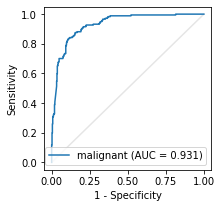

In [12]:
tut_utils.plot_roc_curves(df_result)
plt.show()

### カットオフ値
[Youden's J statistic](https://en.wikipedia.org/wiki/Youden's_J_statistic)をもとにカットオフ値を決める。

cut-off=0.452, sensitivity=0.836, specificity=0.889


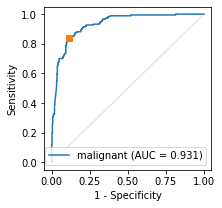

In [13]:
fpr, tpr, thresholds = metrics.roc_curve(df_result['class'],
                                         df_result['pred_proba'])
cutoff_idx = np.argmax(np.array(tpr) - np.array(fpr))
cutoff_fpr, cutoff_tpr, cufoff = fpr[cutoff_idx], tpr[cutoff_idx], thresholds[
    cutoff_idx]
print('cut-off={:.3g}, sensitivity={:.3g}, specificity={:.3g}'.format(
    cufoff, cutoff_tpr, 1 - cutoff_fpr))
tut_utils.plot_roc_curves(df_result)
plt.plot(cutoff_fpr, cutoff_tpr, marker='s')
plt.show()

### Probability Calibration curves

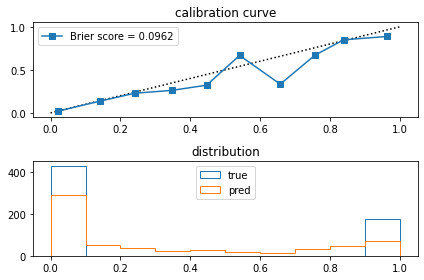

In [14]:
from sklearn.calibration import calibration_curve
fraction_of_positives, mean_predicted_value = calibration_curve(
    df_result['class'], df_result['pred_proba'], n_bins=10)
brier_score = metrics.brier_score_loss(df_result['class'],
                                       df_result['pred_proba'])
plt.subplot(2, 1, 1)
plt.plot([0, 1], [0, 1], 'k:')
plt.plot(mean_predicted_value,
         fraction_of_positives,
         's-',
         label='Brier score = {:.3g}'.format(brier_score))
plt.legend()
plt.title('calibration curve')
plt.subplot(2, 1, 2)
plt.hist(df_result['class'], histtype="step", label='true')
plt.hist(df_result['pred_proba'], histtype="step", label='pred')
plt.title('distribution')
plt.legend(loc='upper center')
plt.tight_layout()
plt.show()